# Working with final df to scale everything.

In [227]:
import pandas as pd
from path import Path

import requests
import pprint
import requests
from requests.exceptions import HTTPError
from datetime import datetime as dt
import pandas as pd
import numpy as np
import timeit
import time
import datetime
import copy

import numpy as np
from sklearn import preprocessing
%matplotlib inline

import pandas as pd
from path import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

import plotly.express as px

import matplotlib.pyplot as plt

In [228]:
file_path = Path("../../../../data/cleandata/test_and_post_ico/ico_test_df.csv")

In [229]:
success_df = pd.read_csv(file_path)

In [230]:
success_df.drop(columns = ['custom_index_scaled','custom_index', 'success_index'], inplace = True)

In [231]:
success_df.head(8)

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA,predicted_NN
0,35.0,0x,ZRX,210898190,0.731445,195643,0.29,-1.20,-4.96,United States of America,...,31,0 days 00:00:00.000000000,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0,0.000003
1,359.0,Perlin,PERL,7547077,0.019287,23506334,0.79,1.16,-8.86,Singapore,...,49,0 days 00:00:00.000000000,0.817167,0.053167,0.830500,0.116000,6.0,367.0,0,0.000003
2,823.0,Medicalchain,MTN,1279470,0.000174,52,-0.20,-34.19,-6.05,United Kingdom,...,86,0 days 00:00:00.000000000,0.746697,0.025394,0.892535,0.082042,71.0,381.0,0,0.000242
3,1310.0,GoPower,GPT,204249,0.000128,0,0.00,-0.06,5.58,NaN,...,60,0 days 00:00:00.000000000,-0.356840,0.016600,0.975800,0.007200,5.0,381.0,0,-0.000017
4,603.0,Swarm,SWM,2752050,0.002171,5,-0.21,-5.07,2.12,Liechtenstein,...,13,0 days 00:00:00.000000000,0.435584,0.069211,0.032684,0.898158,19.0,381.0,0,0.000003
5,447.0,Genesis Vision,GVT,5270656,0.001647,141224,-1.08,-5.29,-5.34,Russia,...,365,0 days 00:00:00.000000000,0.343957,0.034570,0.013290,0.952140,100.0,388.0,0,-0.000312
6,738.0,Lendingblock,LND,1767014,0.012879,232964,0.12,-13.15,-38.12,United Kingdom,...,33,7 days 00:00:00.000000000,0.823980,0.112700,0.032580,0.854730,100.0,390.0,0,-0.000155
7,615.0,Change,CAG,2655421,0.005933,107409,-1.69,-3.16,9.89,NaN,...,2,0 days 00:00:00.000000000,0.726219,0.126562,0.025000,0.848437,16.0,393.0,0,0.000003


# drop unncessary columns and scale all

In [232]:
success_df.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'price', 'volume24',
       'pct1h', 'pct24h', 'pct7d', 'country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'rating', 'status', 'type', 'End', 'Start', 'Duration',
       'pre_Duration', 'compound', 'negative', 'neutral', 'positive',
       'no_of_posts', 'Longevity', 'success_PCA', 'predicted_NN'],
      dtype='object')

In [233]:
success_df.drop(columns = ['Name', 'Ticker','country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'status', 'type', 'End', 'Start', 'predicted_NN', 'success_PCA'], inplace = True)

In [234]:
success_df.columns

Index(['rank_cnc', 'market_cap', 'price', 'volume24', 'pct1h', 'pct24h',
       'pct7d', 'rating', 'Duration', 'pre_Duration', 'compound', 'negative',
       'neutral', 'positive', 'no_of_posts', 'Longevity'],
      dtype='object')

In [235]:
success_df['pre_Duration'].head()

0    0 days 00:00:00.000000000
1    0 days 00:00:00.000000000
2    0 days 00:00:00.000000000
3    0 days 00:00:00.000000000
4    0 days 00:00:00.000000000
Name: pre_Duration, dtype: object

In [236]:
def removing_days(df):
    
    for i in range(len(df)) : 
        #print(str(df.at[i,"pre_Duration"])[:-24])
        df.at[i,'pre_Duration'] = int(str(df.at[i, "pre_Duration"])[:-24])
    return df

In [237]:
removing_days(success_df).head()

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity
0,35.0,210898190,0.731445,195643,0.29,-1.20,-4.96,2.6,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0
1,359.0,7547077,0.019287,23506334,0.79,1.16,-8.86,4.6,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0
2,823.0,1279470,0.000174,52,-0.20,-34.19,-6.05,5.0,86,0,0.746697,0.025394,0.892535,0.082042,71.0,381.0
3,1310.0,204249,0.000128,0,0.00,-0.06,5.58,3.3,60,0,-0.356840,0.016600,0.975800,0.007200,5.0,381.0
4,603.0,2752050,0.002171,5,-0.21,-5.07,2.12,3.5,13,0,0.435584,0.069211,0.032684,0.898158,19.0,381.0


In [251]:
success_df['pre_Duration'] = success_df['pre_Duration'].astype(int64)

NameError: name 'int64' is not defined

In [252]:
# Note above
#removing_days(success_df)

In [250]:
success_df.dtypes

rank_cnc        float64
market_cap        int64
price           float64
volume24          int64
pct1h           float64
pct24h          float64
pct7d           float64
rating          float64
Duration          int64
pre_Duration      int32
compound        float64
negative        float64
neutral         float64
positive        float64
no_of_posts     float64
Longevity       float64
dtype: object

In [253]:
success_df.head(1)

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity
0,35.0,210898190,0.731445,195643,0.29,-1.2,-4.96,2.6,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0


In [254]:
#these kept coming up as an issue... better just to to remove them.
success_df.replace("1,284.19","1284.19", inplace=True)

success_df.replace("-126 d","-126", inplace=True)

In [255]:
# Removing ETH... very successful but highly skewing the processes. Needed when you are using ETH!
#success_df = success_df.iloc[1:]

### Start PCA

In [256]:
success_scaled = StandardScaler().fit_transform(success_df)

In [308]:
success_scaled

array([[-1.47172222,  0.83353949,  0.03201576, ...,  1.15669804,
        -0.83167205, -2.08916508],
       [-0.95133299, -0.10525639, -0.13926436, ..., -0.84052446,
        -0.76221819, -2.06976455],
       [-0.20608422, -0.13419158, -0.1438612 , ..., -0.92200765,
         0.74261533, -1.97922875],
       ...,
       [-1.41711348,  0.21599467,  0.04098865, ..., -0.87668563,
         1.41400259,  3.73099384],
       [-1.29504687, -0.02686795,  2.8047323 , ..., -0.96578079,
        -0.4381002 ,  4.13193812],
       [-1.45244855,  0.42669826,  2.54017285, ..., -0.9107758 ,
         0.60370762,  5.30243675]])

In [257]:
pca = PCA(n_components=3)

In [258]:
success_scaled.shape[1] #number of features... ie, the number of components minus 1 we can use.

16

In [259]:
success_pca = pca.fit_transform(success_scaled)

In [260]:
# Transform PCA data to a DataFrame
df_success_pca = pd.DataFrame(
    data=success_pca, columns=["principal component 1", "principal component 2", 'principal component 3'])
df_success_pca.head()

,principal component 1,principal component 2,principal component 3
0,0.712422,0.081612,0.010500
1,-0.824510,0.115655,1.433278
2,-1.090547,0.002806,2.437817
3,-2.118482,-0.040868,1.143119
4,1.208690,-1.028870,0.310807


In [261]:
pca.explained_variance_ratio_.sum() #horrible but 3 what we need according to the elbow curve

0.39755214205328065

In [262]:
# Finding the best value for k
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_success_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

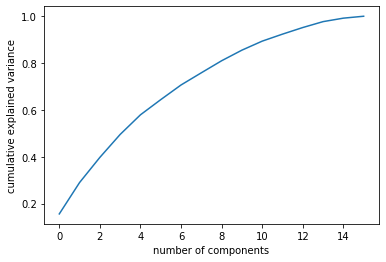

In [263]:
pca = PCA().fit(success_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [264]:
# Predicting clusters with k=3 USED 3 there is an outlier.... 

# Initialize the K-Means model
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(df_success_pca)

# Predict clusters
predictions = model.predict(df_success_pca)

# Add the predicted class columns
df_success_pca["class"] = model.labels_
list(df_success_pca[df_success_pca['class'] == 2].index)

[78, 404, 438, 481, 524]

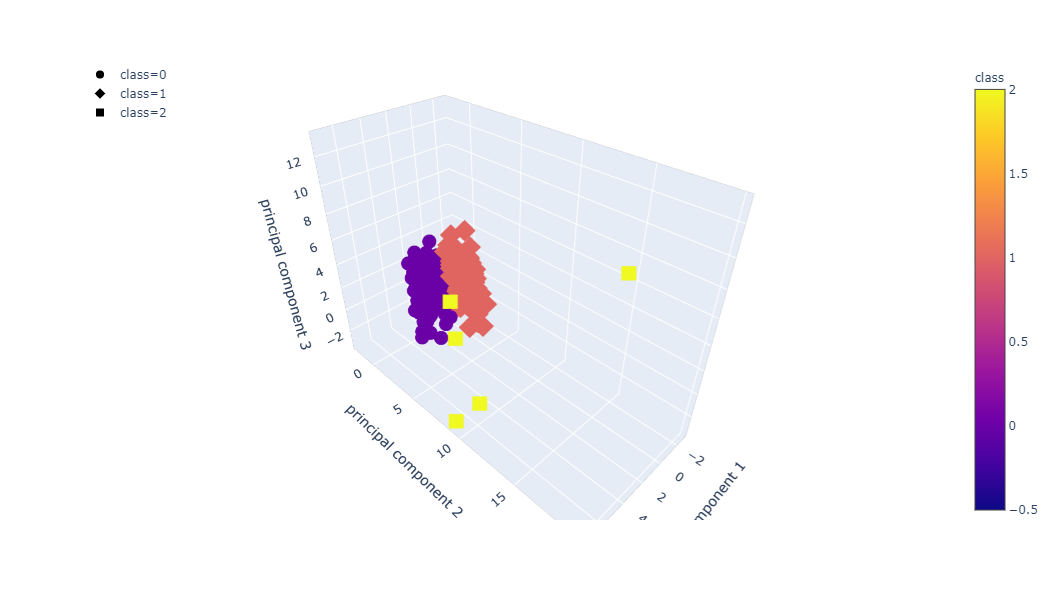

In [265]:
fig = px.scatter_3d(
    df_success_pca,
    x="principal component 1",
    y="principal component 2",
    z="principal component 3",
    color="class",
    symbol="class",
    #size="sepal_width",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

### Outlier removed. The highest market cap was causing this model to fail with a huge outlier.
### Removed. What is shown is now more telling.

In [266]:
success_df_pca_class_2 = pd.read_csv(file_path)

In [287]:
success_df_pca_class_2.drop(columns = ['custom_index','custom_index_scaled','success_index'], inplace = True)

In [288]:
success_df_pca_class_2['success_PCA'] = 0

In [289]:
success_df_pca_class_2.iloc[list(df_success_pca[df_success_pca['class'] == 2].index)]

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Start,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA
78,8.0,Cardano,ADA,3214893394,3.420000,1735988258,0.11,-1.49,-2.55,Switzerland,...,2015-09-01 00:00:00,350,0,0.828470,0.032200,0.858550,0.109270,100.0,522.0,0
404,22.0,Ethereum Classic,ETC,632251075,69.070000,346367843,-0.12,-1.18,-5.06,NaN,...,2017-09-28 03:00:00,0,0,0.663146,0.102770,0.025100,0.872110,100.0,779.0,0
438,23.0,Basic Attenti...,BAT,547458892,4.760000,642121534,-0.20,-2.10,-9.16,United States of America,...,2017-05-31 00:00:00,0,0,0.377329,0.079930,0.037850,0.882180,100.0,779.0,0
481,7.0,EOS,EOS,3277372658,21.070000,231846713,-0.46,-1.33,2.49,Cayman Islands,...,2017-06-26 16:00:00,20,0,0.563773,0.096670,0.041410,0.861890,100.0,848.0,0
524,13.0,Huobi Token,HT,1105888653,0.042654,53437224,-0.50,-1.72,-2.12,Seychelles,...,2017-09-28 03:00:00,488,0,0.589474,0.098387,0.032946,0.868753,93.0,1049.0,0


In [290]:
success_df_pca_class_2.at[list(df_success_pca[df_success_pca['class'] == 2].index),'success_PCA']=1

In [291]:
success_df_pca_class_2.iloc[list(df_success_pca[df_success_pca['class'] == 2].index)]['success_PCA']

78     1
404    1
438    1
481    1
524    1
Name: success_PCA, dtype: int64

In [292]:
success_df_pca_class_2.head()

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Start,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA
0,35.0,0x,ZRX,210898190,0.731445,195643,0.29,-1.20,-4.96,United States of America,...,2017-08-15 00:00:00,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0
1,359.0,Perlin,PERL,7547077,0.019287,23506334,0.79,1.16,-8.86,Singapore,...,2017-09-28 03:00:00,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0,0
2,823.0,Medicalchain,MTN,1279470,0.000174,52,-0.20,-34.19,-6.05,United Kingdom,...,2018-02-01 00:00:00,86,0,0.746697,0.025394,0.892535,0.082042,71.0,381.0,0
3,1310.0,GoPower,GPT,204249,0.000128,0,0.00,-0.06,5.58,NaN,...,2018-02-27 00:00:00,60,0,-0.356840,0.016600,0.975800,0.007200,5.0,381.0,0
4,603.0,Swarm,SWM,2752050,0.002171,5,-0.21,-5.07,2.12,Liechtenstein,...,2017-10-21 12:00:00,13,0,0.435584,0.069211,0.032684,0.898158,19.0,381.0,0


In [293]:
success_df_pca_class_2.drop(columns = ['predicted_NN'], inplace = True)

KeyError: "['predicted_NN'] not found in axis"

In [294]:
success_df.head(2)

,rank_cnc,market_cap,price,volume24,pct1h,pct24h,pct7d,rating,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity
0,35.0,210898190,0.731445,195643,0.29,-1.20,-4.96,2.6,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0
1,359.0,7547077,0.019287,23506334,0.79,1.16,-8.86,4.6,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0


In [295]:
success_df_pca_class_2.replace("1,284.19","1284.19", inplace=True)

success_df_pca_class_2.replace("-126 d","-126", inplace=True)

In [296]:
success_df_pca_class_2.shape

(535, 27)

In [297]:
success_df.shape

(535, 16)

In [298]:
a = set(success_df_pca_class_2['rank_cnc']) 
b = set(success_df['rank_cnc'])
c=(a^b)&b
d=(a^b)&a

In [299]:
d

set()

In [300]:
c

set()

In [301]:
def check_what_matches(df1,df2):
    duplicates = []
    
    for ticker1 in df1['rank_cnc'].tolist():
        for ticker2 in df2['rank_cnc'].tolist():
            if ticker1 != ticker2:
                duplicates.append(ticker1)
            else:
                continue
    return duplicates

In [302]:
# check_what_matches(success_df, success_df_pca_class_2)

In [303]:
#doing it manually.... iterations were not working at all... :\
success_df.columns

Index(['rank_cnc', 'market_cap', 'price', 'volume24', 'pct1h', 'pct24h',
       'pct7d', 'rating', 'Duration', 'pre_Duration', 'compound', 'negative',
       'neutral', 'positive', 'no_of_posts', 'Longevity'],
      dtype='object')

In [304]:
success_df_pca_class_2.columns

Index(['rank_cnc', 'Name', 'Ticker', 'market_cap', 'price', 'volume24',
       'pct1h', 'pct24h', 'pct7d', 'country', 'platform', 'pre_ico_end',
       'pre_ico_start', 'rating', 'status', 'type', 'End', 'Start', 'Duration',
       'pre_Duration', 'compound', 'negative', 'neutral', 'positive',
       'no_of_posts', 'Longevity', 'success_PCA'],
      dtype='object')

In [305]:
for columns in list(success_df.columns):
    success_df_pca_class_2[columns] = success_df[columns]

In [306]:
success_df_pca_class_2.head()

,rank_cnc,Name,Ticker,market_cap,price,volume24,pct1h,pct24h,pct7d,country,...,Start,Duration,pre_Duration,compound,negative,neutral,positive,no_of_posts,Longevity,success_PCA
0,35.0,0x,ZRX,210898190,0.731445,195643,0.29,-1.20,-4.96,United States of America,...,2017-08-15 00:00:00,31,0,-0.115233,0.022333,0.029333,0.948333,3.0,364.0,0
1,359.0,Perlin,PERL,7547077,0.019287,23506334,0.79,1.16,-8.86,Singapore,...,2017-09-28 03:00:00,49,0,0.817167,0.053167,0.830500,0.116000,6.0,367.0,0
2,823.0,Medicalchain,MTN,1279470,0.000174,52,-0.20,-34.19,-6.05,United Kingdom,...,2018-02-01 00:00:00,86,0,0.746697,0.025394,0.892535,0.082042,71.0,381.0,0
3,1310.0,GoPower,GPT,204249,0.000128,0,0.00,-0.06,5.58,NaN,...,2018-02-27 00:00:00,60,0,-0.356840,0.016600,0.975800,0.007200,5.0,381.0,0
4,603.0,Swarm,SWM,2752050,0.002171,5,-0.21,-5.07,2.12,Liechtenstein,...,2017-10-21 12:00:00,13,0,0.435584,0.069211,0.032684,0.898158,19.0,381.0,0


In [307]:
file_path = Path("../../../../data/cleandata/success_PCA_df.csv")
success_df_pca_class_2.to_csv(file_path, index=False)